# Special Interest Group Ratings EDA

Taking a look at the SIG candidate ratings by different rating categories in terms of overall stats, data quality and potential incorporation into the ML model.

We are using the denormalized votesmart dataset file

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind

In [2]:
full_df = pd.read_csv('data/votesmart_denormalized.csv')

## Data Prep

The first look is going to be only at the two major parties, but keeping the full data frame in case we want to look at it later.

In [32]:
# Data prep and filtering
full_df['rating'] = pd.to_numeric(full_df['rating'], errors='coerce')
full_df = full_df[~np.isnan(full_df['rating'])]
full_df['sigName'] = full_df['nameleft']
df = full_df[full_df['party'].isin(['Republican', 'Democrat'])]

In [5]:
df.head()

,Unnamed: 0,Unnamed: 0left,candidateIdleft,rating,ratingIdleft,last_name,first_name,gender,type,state,...,sigIdleft2,nameleft2,Unnamed: 0left.1,categoryIdleft,nameleft,sigId,sigParentId,Unnamed: 0.1,categoryId,name
5,209603,209603,2919,79.0,5953,Chamberlain,Ebenezer,M,rep,IN,...,211,Rhode Island National Federation of Independen...,211,4,National Association of Wheat Growers,684,-1,4,7,"Arts, Entertainment, and History"
7,209614,209614,6098,31.0,5953,Jones,James,M,sen,AR,...,211,Rhode Island National Federation of Independen...,211,4,National Association of Wheat Growers,684,-1,4,7,"Arts, Entertainment, and History"
8,209615,209615,379,52.0,5953,Maloney,Sean,M,rep,NY,...,211,Rhode Island National Federation of Independen...,211,4,National Association of Wheat Growers,684,-1,4,7,"Arts, Entertainment, and History"
10,209616,209616,515,41.0,5953,Gottheimer,Josh,M,rep,NJ,...,211,Rhode Island National Federation of Independen...,211,4,National Association of Wheat Growers,684,-1,4,7,"Arts, Entertainment, and History"
11,209616,209616,515,41.0,5953,Van Horne,Archibald,M,rep,MD,...,211,Rhode Island National Federation of Independen...,211,4,National Association of Wheat Growers,684,-1,4,7,"Arts, Entertainment, and History"


Over 100,000 rows with each row representing an individual rating of a candidate by a special interest group in a specific rating category

In [6]:
df.shape

(102105, 27)

In [7]:
df.columns

Index([u'Unnamed: 0', u'Unnamed: 0left', u'candidateIdleft', u'rating',
       u'ratingIdleft', u'last_name', u'first_name', u'gender', u'type',
       u'state', u'party', u'candidateId', u'sigIdleft', u'ratingId',
       u'ratingName', u'timespan', u'Unnamed: 0left2', u'sigIdleft2',
       u'nameleft2', u'Unnamed: 0left.1', u'categoryIdleft', u'nameleft',
       u'sigId', u'sigParentId', u'Unnamed: 0.1', u'categoryId', u'name'],
      dtype='object')

How many legislators do we have in each party?

In [24]:
df['party'].value_counts()

Republican    59169
Democrat      42936
Name: party, dtype: int64

In [13]:
print('Number of categories:', len(df['name'].unique()))
print('Category counts:')
df['name'].value_counts()

('Number of categories:', 20)
Category counts:


Drugs                                     17286
Agriculture and Food                      13432
Veterans                                  11863
Women                                     11758
Science                                    9568
Employment and Affirmative Action          7498
Business and Consumers                     5214
Unemployed and Low-Income                  4680
Marriage, Family, and Children             3866
Arts, Entertainment, and History           3598
Senior Citizens                            3335
Housing and Property                       2130
Guns                                       1890
Civil Liberties and Civil Rights           1785
Sexual Orientation and Gender Identity     1603
National Security                          1382
Animals and Wildlife                        425
Federal, State and Local Relations          417
Labor Unions                                254
Education                                   121
Name: name, dtype: int64

## Rating System

In order for the rating system to be useful, it should be consistently applied by special interest groups across the board, ideally with a numeric scale from low to high on a liberal/conservative spectrum (doesn't matter which is high or low). 

If they are consistently applied, we may be able to label SIGs are generaly supporting liberal or conservative agendas. However, this may not be necessary if we just use the raw scores as the base for derived features in the model.

First, we'll take a look at if there are differences in average ratings between parties across all categories:

In [8]:
df.groupby(['name', 'party'])['rating'].mean()

name                                    party     
Agriculture and Food                    Democrat      57.743181
                                        Republican    56.549253
Animals and Wildlife                    Democrat      52.005814
                                        Republican    59.822134
Arts, Entertainment, and History        Democrat      53.494505
                                        Republican    52.275910
Business and Consumers                  Democrat      55.851417
                                        Republican    54.844023
Civil Liberties and Civil Rights        Democrat      59.635514
                                        Republican    58.642626
Drugs                                   Democrat      56.239687
                                        Republican    55.222114
Education                               Democrat      69.604651
                                        Republican    77.320513
Employment and Affirmative Action       Democrat     

**Results:** 
* It looks like many of the categories have very similar scores (within 2 points of each other)
    - Surprisingly, Guns falls into this category....
* May indicate that ratings are inconsistently applied or no significant difference
* Categories with differences > 2:
    - Animals and Wildlife (Republicans +7)
    - Education (Republicans +8)
    - Federal, State and Local Relations (Democrats +4)
    - Marriage, Family, and Children (Democrats +6)
    - National Security (Republicans +4)

It looks like there is a minor practical effect in certain areas, but is this statistically significant?

In [23]:
result = ttest_ind(df[df['party']=='Republican']['rating'], df[df['party']=='Democrat']['rating'])
print('P-Value: ' + str(result[1]))
result2 = df.groupby(['party'])['rating'].mean()
print('Ratings Average Difference Across Parties: ' + str(np.round(np.abs(result2[0]-result2[1]), 2)))

P-Value: 8.74798674849e-08
Ratings Average Difference Across Parties: 1.23


**Results:** 

* A p-value of `8.75e-08` from a T-test indicates statistically significant difference across all categories. 
* The practical significance seems to be very small.. which again prompts us to see whether or not the data is valid or just averages out across the two parties

We can visually inspect the distribution by plotting the histograms of the two parties.

The initial plot contained some erroneous values `<0` and `>100`, so I have removed those values in the charts and probaby should do so in the initial data preparation step going forwards

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1104f4750>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x110550410>], dtype=object)

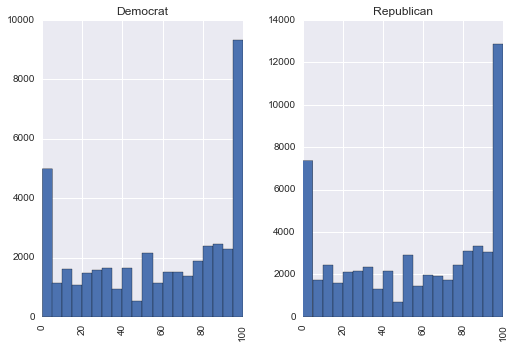

In [30]:
df[(df['rating'] >= 0) & (df['rating'] <= 100)].hist(column='rating', by='party', bins=20)

### SIG Deep Dive

We can only tell so much with the high level data, so we can do a deep dive on a few specific well-known SIGs where we know what they support.

Here are the SIGs with the most candidate ratings:

In [47]:
df['sigName'].value_counts()[0:50]

National Rifle Association Political Victory Fund            4379
Illinois Policy Institute                                    2149
Wyoming Family Coalition                                     1950
West Virginia National Federation of Independent Business    1922
United States Chamber of Commerce                            1919
Food Policy Action                                           1730
Citizen Action Illinois                                      1605
Mississippi Farm Bureau Federation                           1575
Voices for Creative Nonviolence                              1489
Animal Welfare Institute                                     1325
Massachusetts League of Enviromental Voters                  1225
Planned Parenthood Advocates of Michigan                     1218
Eagle Forum of Alabama                                       1215
Partnership for America                                      1178
Planned Parenthood Votes Northwest and Hawaii                1089
Capitol We

NRA and Planned Parenthood and their stances are well-known and documented, so we will focus on their ratings for some of their top SIGs. 

It looks like there are multiple Planned Parenthood organizations. May be worth looking into fuzzy matching to see if we can group related SIGs together.

In [37]:
nraIds = df[df['sigName']=='National Rifle Association Political Victory Fund']['sigId'].unique()
ppNames = ['Planned Parenthood Advocates of Michigan', 'Planned Parenthood Votes Northwest and Hawaii']
ppIds = df[df['sigName'].isin(ppNames)]['sigId'].unique()

In [39]:
print('NRA IDs:' + str(nraIds))
print('Planned Parenthood IDs: ' + str(ppIds))

NRA IDs:[ 924  581 1836 1324  738  446 1564  219  580  714 1496   99]
Planned Parenthood IDs: [ 492 2468  294 2467]


In [49]:
len(df[df['sigId'].isin(ppIds)])

2307

#### NRA

In [45]:
df[df['sigId'].isin(nraIds)].groupby(['name', 'party'])['rating'].mean()

name      party     
Veterans  Democrat      56.505579
          Republican    55.041594
Name: rating, dtype: float64

In [46]:
df[df['sigId'].isin(ppIds)].groupby(['name', 'party'])['rating'].mean()

name                  party     
Agriculture and Food  Democrat      53.253870
                      Republican    50.856061
Women                 Democrat      56.545241
                      Republican    55.764460
Name: rating, dtype: float64

### Legislator Deep Dive

In [51]:
df[df['last_name'] == 'McCain']

,Unnamed: 0,Unnamed: 0left,candidateIdleft,rating,ratingIdleft,last_name,first_name,gender,type,state,...,nameleft2,Unnamed: 0left.1,categoryIdleft,nameleft,sigId,sigParentId,Unnamed: 0.1,categoryId,name,sigName


In [58]:
candidates = pd.concat([pd.read_csv('data/legislators-current.csv'), pd.read_csv('data/legislators-historical.csv')])

In [64]:
candidates[candidates['last_name'] == 'McCain']['votesmart_id']

198    53270.0
Name: votesmart_id, dtype: float64

In [ ]:
candidate_ratings = pd.read_csv('data/candidate_ratings.csv')

In [65]:
candidate_ratings.columns

Index([u'Unnamed: 0', u'candidateId', u'rating', u'ratingId'], dtype='object')

In [66]:
(candidate_ratings['candidateId'] == 53270).sum()

1417